In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

EPOCHS=30
BATCH_SIZE=2
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0005

TRAIN_IMAGE_DIR = "combined_coco/train/images"
TRAIN_ANNOTATION_PATH = "combined_coco/train.json"
VAL_IMAGE_DIR = "combined_coco/valid/images"
VAL_ANNOTATION_PATH = "combined_coco/val.json"

train_transform = transforms.Compose([
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.ToTensor()
])
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoDetectionDataset(Dataset):
    # Init function: loads annotation file and prepares list of image IDs
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
 
    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)
 
    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")
 
        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
 
        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])
 
        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations],    dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)
 
        # Package everything into a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
 
        # Apply transforms if any were passed
        if self.transforms:
            image = self.transforms(image)
            # target['boxes'] = self.transforms(target['boxes'])
 
        return image, target
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
 
# Transform PIL image --> PyTorch tensor
def get_transform():
    return ToTensor()
 
# Load training dataset
train_dataset = CocoDetectionDataset(
    image_dir="combined_coco/train/images", 
    annotation_path="combined_coco/train.json",
    transforms=train_transform
)
 
# Load validation dataset
val_dataset = CocoDetectionDataset(
    image_dir="combined_coco/valid/images",
    annotation_path="combined_coco/val.json",
    transforms=val_transform
)
 
# Load dataset with DataLoaders, you can change batch_size 
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


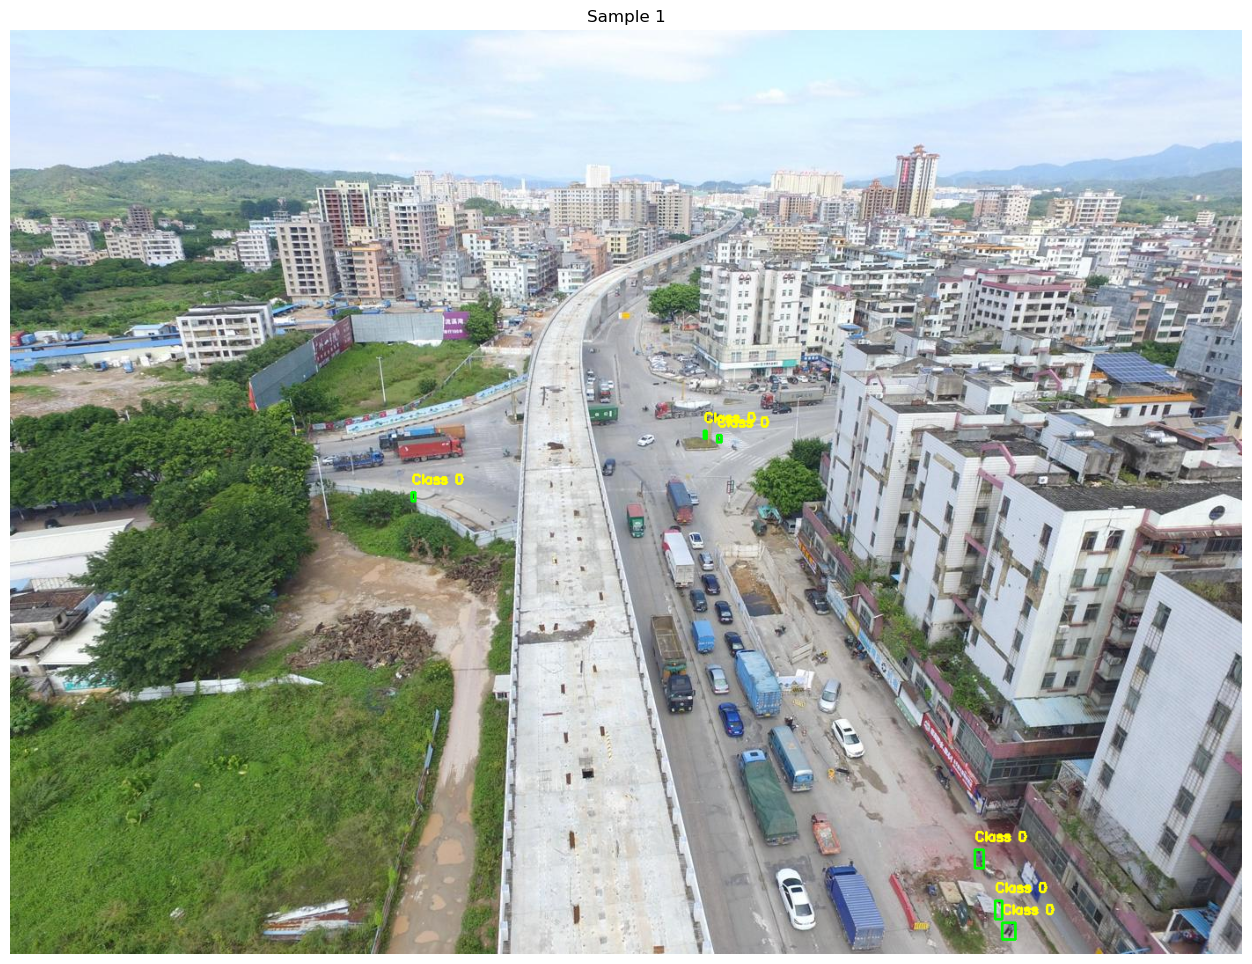

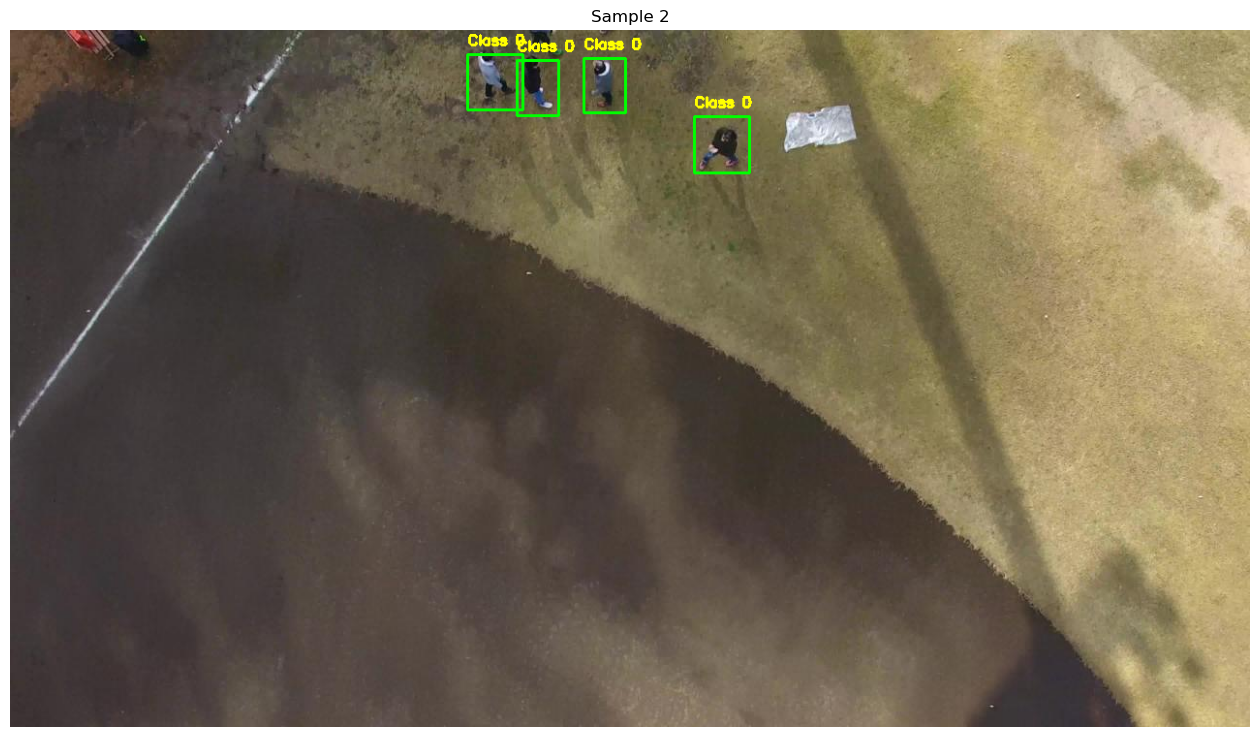

In [3]:
# Get one batch
images, targets = next(iter(train_loader))
 
# loop through one batch and draw bounding boxes and labels
for i in range(len(images)):
    # CxHxW --> HxWxC
    image = images[i].permute(1, 2, 0).numpy()   
    # Rescale
    image = (image * 255).astype(np.uint8)   
    # Convert RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    # get bounding box coordinates and labels
    boxes = targets[i]['boxes']
    labels = targets[i]['labels']
 
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Class {label.item()}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
 
    # Show image with bboxes using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()

In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN, , you change this 
model =torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# Number of classes in the dataset (including background)
# +1 for bg class
num_classes = len(train_dataset.coco.getCatIds()) + 1 
 
# Number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
 
"""  
Number of classes must be equal to your label number
"""
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
# Move the model to the GPU for faster training
model.to(device)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/furkan/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 77.5MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
 
# Define the optimizer SGD(Stochastic Gradient Descent) 
optimizer = torch.optim.Adam(params, lr=0.005,
                             weight_decay=0.0005)


In [7]:
from engine import train_one_epoch, evaluate
 
# Number of epochs for training
num_epochs = 10
 
# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
 
    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training
 
    # Evaluate the model only on the validation dataset, not training
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation
 
    # save the model after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")



Epoch 1/10


/Users/furkan/Documents/TU_Wien/CVSystemProgramming/Project/Tracking-People-in-Aerial-Footage/faster_rcnn/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [   0/4489]  eta: 16 days, 7:16:01  lr: 0.000010  loss: 1.9453 (1.9453)  loss_classifier: 0.7577 (0.7577)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 1.0637 (1.0637)  loss_rpn_box_reg: 0.1239 (0.1239)  time: 313.7806  data: 0.0843


KeyboardInterrupt: 